### Visualisation with Bokeh
This is just a simple piece of visualisation code to display the text data which has been processed in other notebooks.  

In [1]:
print('------------------------------------------------------')
print('Step 5:  Creating visualisation')
from datetime import datetime as dt
print(dt.now())
print('------------------------------------------------------')

------------------------------------------------------
Step 5:  Creating visualisation
2018-06-12 15:31:49.053012
------------------------------------------------------


In [2]:
import pandas as pd
import numpy as np
import pickle

# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


from bokeh.plotting import *
# from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.models import *
from bokeh.io import output_notebook

In [3]:
from config import Config as c
tfidf_filename = c.tfidf_filename
bar_filename = c.bar_filename
plot_title = c.title
doi_datapath = c.dois_pkl
working_data = c.working_data
set_name = c.set_name
# test_set = c.test_set
n_clusters = c.n_clusters
journal_of_interest = c.joi

In [4]:
# global variable
dois = pickle.load(open(doi_datapath,'rb'))

In [5]:
# read data
data = pd.read_csv(c.working_data,index_col = 0)
# data["Cluster_no"] = data["Cluster_no"].astype('category')
data.sample(5)

,DI,PY,TI,AB,WD,AU,EM,AF,SO,SC,...,highly_cited_1,highly_cited_10,highly_cited_5,recent_citations,relative_citation_ratio,times_cited,Citations,Cluster,Cluster_no,Article_kws
867,10.1016/j.ijedudev.2012.08.005,2013,Promoting access to education for disabled chi...,"Poor people are most likely to be disabled, an...",Promoting access to education for disabled chi...,"Croft, A",a.m.croft@sussex.ac.uk,"Croft, Alison",INTERNATIONAL JOURNAL OF EDUCATIONAL DEVELOPMENT,Education & Educational Research,...,False,False,False,7,NaN,12,12,"['disabl', 'children', 'vaccin']",9,"['disabl', 'educ', 'inclus']"
196,10.1111/cch.12165,2015,Definitions of sleeplessness in children with ...,BackgroundSleep disturbances are common in chi...,Definitions of sleeplessness in children with ...,"Montgomery, P; Wiggs, L",paul.montgomery@spi.ox.ac.uk,"Montgomery, P.; Wiggs, L.",CHILD CARE HEALTH AND DEVELOPMENT,Psychology; Pediatrics,...,False,False,False,4,0.18,4,4,"['sleep', 'adhd', 'problem']",7,"['sleepless', 'definit', 'adhd']"
323,10.1111/cch.12050,2013,The youth report version of the Child and Adol...,Objective The Child and Adolescent Scale of Pa...,The youth report version of the Child and Adol...,"McDougall, J; Bedell, G; Wright, V",janette.mcdougall@tvcc.on.ca,"McDougall, J.; Bedell, G.; Wright, V.",CHILD CARE HEALTH AND DEVELOPMENT,Psychology; Pediatrics,...,False,False,False,10,2.10,18,18,"['motor', 'children', 'development']",3,"['casp', 'youth', 'report']"
1244,10.1177/1367493511403953,2011,"Polyunsaturated fatty acids, cognition and lit...",Suboptimal omega-3 polyunsaturated fatty acid ...,"Polyunsaturated fatty acids, cognition and lit...","Milte, CM; Sinn, N; Buckley, JD; Coates, AM; Y...",natalie.sinn@unisa.edu.au,"Milte, Catherine M.; Sinn, Natalie; Buckley, J...",JOURNAL OF CHILD HEALTH CARE,Nursing; Pediatrics,...,False,False,False,6,1.49,23,23,"['sleep', 'adhd', 'problem']",7,"['pufa', 'beta', 'acid']"
242,10.1111/cch.12061,2014,Early parental physical punishment and emotion...,ObjectiveTo determine whether there is an asso...,Early parental physical punishment and emotion...,"Scott, S; Lewsey, J; Thompson, L; Wilson, P",sonyascott@nhs.net,"Scott, S.; Lewsey, J.; Thompson, L.; Wilson, P.",CHILD CARE HEALTH AND DEVELOPMENT,Psychology; Pediatrics,...,False,False,False,1,0.20,2,2,"['depress', 'infant', 'behaviour']",15,"['smack', 'caregiv', 'sdq']"


## Set NaNs in citations col to zero.

In [6]:
data['Citations'] = data['Citations'].fillna(0)

In [7]:
print('Showing data for the following journals:')
print(data['SO'].value_counts())

Showing data for the following journals:
CHILD CARE HEALTH AND DEVELOPMENT                   559
INTERNATIONAL JOURNAL OF EDUCATIONAL DEVELOPMENT    485
JOURNAL OF CHILD HEALTH CARE                        232
JOURNAL OF RESEARCH IN CHILDHOOD EDUCATION           76
Name: SO, dtype: int64


In [8]:
# for col in data.columns:
#     print(col,': ',sum(data[col].isnull()))

## Bokeh code
The first step is to define a few things that will go into the plot.

#### Hover tool
The hover tool defines what happens when you hover your mouse over the plot. 

In [9]:
hover = HoverTool(
        tooltips=[
#             ("index", "$index"),
#             ("(x,y)", "($x, $y)"),
            ("Journal", "@SO"),
            ("DOI", "@DI"),
            ("Article Keywords","@Article_kws"),
            ("Citations", "@Citations"),
            ("Cluster_no", "@Cluster_no"),
            ("Cluster Keywords","@Cluster")
                ])

In [10]:
output_notebook()

Loading BokehJS ...

#### Other tools
Other tools to add to the right hand side of the plot can be selected from a list.

In [11]:
TOOLS = [BoxSelectTool(), hover, 'tap','box_zoom','reset', 'crosshair'] #,HoverTool()] # just say 'HoverTool()' for the default

## Add Alpha and size data

'Alpha' is the transparency or 'brightness' of the dots.  The formula below ensures that low-cited articles are dimmer than the bright ones.  This has quite a subtle effect on the final plot and can be removed, but it does help to make individual articles stand out , even if their coloring puts then in a group that has low citations.

'Sizes' is our setting for the size of the dots.  I used to use this to help accentuate highly cited papers, but I decided that it made the plot look cluttered.  Perhaps it's worth uncommenting this line if you are using a small dataset.

In [12]:
# data['Sizes'] = 3+(1.5*(np.log(1+data.Citations)))

# normalize citations to max 1 and attenuate with log so that we don't have a spike
normed = np.log10(1+data.Citations)/np.log10(1+np.max(data.Citations))
# set minimum alpha
min_alpha = 0.2
# set max alpha
max_alpha = 1.0
# set alpha
data['Alpha'] = min_alpha + ( (max_alpha-min_alpha)*normed )

## Colour clusters by average citation rates
This is where we define our colour scheme. 

In [13]:

sns.palplot(sns.color_palette("YlOrRd", 50)[::-1])

In [14]:
data[data['Citations']==100]

,DI,PY,TI,AB,WD,AU,EM,AF,SO,SC,...,highly_cited_10,highly_cited_5,recent_citations,relative_citation_ratio,times_cited,Citations,Cluster,Cluster_no,Article_kws,Alpha
477,10.1111/j.1365-2214.2011.01282.x,2011,A social-ecological model of readiness for tra...,Background Policy and research related to tran...,A social-ecological model of readiness for tra...,"Schwartz, LA; Tuchman, LK; Hobbie, WL; Ginsber...",schwartzl@email.chop.edu,"Schwartz, L. A.; Tuchman, L. K.; Hobbie, W. L....",CHILD CARE HEALTH AND DEVELOPMENT,Psychology; Pediatrics,...,True,True,59,5.52,100,100,"['transit', 'adult', 'care']",17,"['smart', 'transit', 'readi']",0.985472


In [15]:
cit_col_ls = []

av_years = c.av_years # this won't work if you have zero articles from these years in a particular cluster.  Use with care or just set to c.years

avcits = data[data['PY'].isin(av_years)].groupby('Cluster_no')['Citations'].mean()
maxav = avcits.max()
minav = avcits.min()
avrange = maxav-minav

# define the palette
palette = sns.color_palette("YlOrRd", n_clusters+1).as_hex()[::-1] # note +1 to fix rounding errors
# palette2 = ['#%02x%02x%02x'%(int(y) for y in x) for x in palette]
# palette2
i=0
so = data['SO'].tolist()
color_numerics=[]
for cl_no in data['Cluster_no'].tolist():
    
    if so[i] == journal_of_interest:
        cit_col_ls.append('#7ec0ee') # this colour is a bright sky-blue.  'green' or maybe purple would show up well, too
    else:
        cl_avcit = n_clusters*(avcits[cl_no]-minav)/avrange # gets the relative position of the cluster's average cites in the distribution
        color_numerics.append(cl_avcit)
        colr = palette[int(cl_avcit)]
        cit_col_ls.append(colr)
    i+=1
data['Cit_col'] = cit_col_ls   
# cit_col_ls

Check the distribution of the colours.  In some datasets, you'll find a poor distribution of red/orange/yellow simply due to the distribution of citations in the dataset.  Worth fiddling with the code to make the diferences stand out.  

In [16]:
pd.Series(color_numerics).hist()

## Build plot
This is where we define the figure itself using the Bokeh package.

In [17]:
from bokeh.io import show
from bokeh.models import ColumnDataSource
from bokeh.palettes import RdBu3
from bokeh.plotting import figure

# https://stackoverflow.com/questions/41856999/bokeh-plots-just-bring-up-a-blank-window
# BOKEH_RESOURCES=inline


# plotting
p = figure(plot_width=950, plot_height=600,
           title=plot_title,  # specified in the config file!
           tools=TOOLS,
          x_axis_label = "Textual similarity axis_1 (arbitrary units)",
          y_axis_label = 'Textual similarity axis_2 (arbitrary units)') # , active_inspect=None)

# p.toolbar.active_inspect = ['crosshair', hover]

p.background_fill_color = "black"

p.circle(x = 'TSNE1', 
         y = 'TSNE2', 
#           legend = 'Division',
         size = 5, # 'Sizes',
         color = 'Cit_col', # Cit_col',#'j_col', #'cit_colr', # #841F27', #'Color',
         alpha = 'Alpha', 
         line_alpha = 0,
         source = ColumnDataSource(data))  # This conversion to ColumnDataSource is crucial.

p.legend.location = "bottom_right"
# p.legend.text = div_colors

output_file(tfidf_filename,
           mode = 'inline')  # toggle for write-to-file


# add links
url = "@Link"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

In [18]:
show(p)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Add bar plots
Now that the plot is completed, there are a few simple images that might help to describe the data.

In [19]:
# % matplotlib inline
df = pd.read_csv('data/cluster_data.csv', index_col=0)
df.sample(1)

,Cluster,cites,dois_ls,mean_cites,nz_cites,len_cites,Cluster_no,nz_pc
5,"['educ', 'school', 'enrol']","[14, 5, 2, 0, 1, 3, 0, 0, 0, 1, 3, 0, 1, 1, 2,...","['10.1111/j.1365-2214.2011.01327.x', '10.1111/...",4.904762,72.0,84,5,0.857143


In [20]:
df.dtypes

Cluster        object
cites          object
dois_ls        object
mean_cites    float64
nz_cites      float64
len_cites       int64
Cluster_no      int64
nz_pc         float64
dtype: object

In [21]:
# Convert Cluster to category data type
df['Cluster'] = df['Cluster'].astype(str).astype('category', ordered = True)
#check
df.dtypes

C:\Users\aday\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


Cluster       category
cites           object
dois_ls         object
mean_cites     float64
nz_cites       float64
len_cites        int64
Cluster_no       int64
nz_pc          float64
dtype: object

### With Seaborn
Means first

### Box plots

In [ ]:
x = 'Cluster'
y = 'mean_cites'

df.Cluster = df.sort_values(y).Cluster
df = df.sort_values(y, ascending = False)
df.Cluster.cat.ordered
# df['Cluster'] = df['Cluster'].cat.reorder_categories(list(df['Cluster']), ordered=True)

In [39]:
data['Cluster'] = data['Cluster'].astype('category')
data['Cluster'].dtype

CategoricalDtype(categories=['['activ', 'sibl', 'food']',
                  '['children', 'health', 'adolesc']',
                  '['depress', 'infant', 'behaviour']',
                  '['disabl', 'children', 'vaccin']',
                  '['dropout', 'hiv', 'migrat']',
                  '['educ', 'develop', 'learn']',
                  '['educ', 'higher', 'univers']',
                  '['educ', 'school', 'enrol']', '['gender', 'girl', 'educ']',
                  '['hospit', 'nurs', 'asthma']',
                  '['literaci', 'read', 'instruct']',
                  '['motor', 'children', 'development']',
                  '['obes', 'weight', 'overweight']',
                  '['pain', 'children', 'adolesc']',
                  '['parent', 'child', 'famili']',
                  '['school', 'student', 'privat']',
                  '['servic', 'care', 'famili']',
                  '['sleep', 'adhd', 'problem']',
                  '['teacher', 'educ', 'student']',
                  '['t

In [43]:
data['times_cited'].unique()

array([  1,   2,   0,   4,   7,   3,   5,  11,   8,   9,   6,  10,  12,
        13,  16,  14,  20,  19,  15,  41,  21,  26,  25,  18,  17,  35,
        29,  23,  32,  33,  45,  27,  43,  52,  34,  38,  28,  30,  22,
        42, 109,  37, 100,  50,  39,  51,  48,  24,  31,  72,  46,  68,
        40,  44,  49,  58], dtype=int64)

C:\Users\aday\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


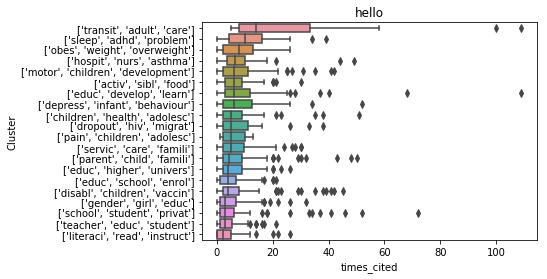

In [55]:
%matplotlib inline
# df.Cluster = df.sort_values('times_cited').Cluster
ax = sns.boxplot('times_cited',
                 'Cluster', 
                 orient='h', 
                 order = list(df.Cluster),
                 data = data).set_title('Boxplots for citation rates of various k-means clusters')

In [22]:
x = 'Cluster'
y = 'mean_cites'

df.Cluster = df.sort_values(y).Cluster
df = df.sort_values(y, ascending = False)
df.Cluster.cat.ordered
# df['Cluster'] = df['Cluster'].cat.reorder_categories(list(df['Cluster']), ordered=True)

True

In [50]:
list(df.Cluster)

19            ['transit', 'adult', 'care']
17            ['sleep', 'adhd', 'problem']
12        ['obes', 'weight', 'overweight']
9             ['hospit', 'nurs', 'asthma']
11    ['motor', 'children', 'development']
0                ['activ', 'sibl', 'food']
5             ['educ', 'develop', 'learn']
2       ['depress', 'infant', 'behaviour']
1        ['children', 'health', 'adolesc']
4             ['dropout', 'hiv', 'migrat']
13         ['pain', 'children', 'adolesc']
16            ['servic', 'care', 'famili']
14           ['parent', 'child', 'famili']
6            ['educ', 'higher', 'univers']
7              ['educ', 'school', 'enrol']
3         ['disabl', 'children', 'vaccin']
8               ['gender', 'girl', 'educ']
15         ['school', 'student', 'privat']
18          ['teacher', 'educ', 'student']
10        ['literaci', 'read', 'instruct']
Name: Cluster, dtype: category
Categories (20, object): [['activ', 'sibl', 'food'], ['children', 'health', 'adolesc'], ['depress', 'infant',

In [33]:
data.columns

Index(['DI', 'PY', 'TI', 'AB', 'WD', 'AU', 'EM', 'AF', 'SO', 'SC', 'SN', 'EI',
       'TC', 'Z9', 'C1', 'TSNE1', 'TSNE2', 'DOI', 'Link',
       'field_citation_ratio', 'highly_cited_1', 'highly_cited_10',
       'highly_cited_5', 'recent_citations', 'relative_citation_ratio',
       'times_cited', 'Citations', 'Cluster', 'Cluster_no', 'Article_kws',
       'Alpha', 'Cit_col'],
      dtype='object')

In [23]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(20, 12))
p = sns.barplot(data = df, 
            x=df[y],
            y=df[x],
            color = 'b',
            orient='h',
            order = df[x]).set_title('Citation rates for {} split into {} K-Means clusters'.format(c.set_name,c.n_clusters))
# p.set_xticklabels(labels = df[x],rotation=90)
ax.set(xlabel='Mean citations', ylabel='Cluster')
plt.savefig('outputs/K_Means_Barplot_means_k{}.png'.format(n_clusters))
p

C:\Users\aday\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Citation rates for Continuity in education split into 20 K-Means clusters')

Now plot the medians

In [24]:
import seaborn as sns

df = pd.DataFrame(data.groupby('Cluster')['Citations'].median())
df.reset_index(level=0, inplace=True)

In [25]:
df.columns = ['Cluster', 'Median citations']
df.Cluster = df.Cluster.astype('category')
df.head()

,Cluster,Median citations
0,"['activ', 'sibl', 'food']",6.0
1,"['children', 'health', 'adolesc']",5.0
2,"['depress', 'infant', 'behaviour']",6.0
3,"['disabl', 'children', 'vaccin']",4.0
4,"['dropout', 'hiv', 'migrat']",5.0


In [26]:
x = 'Cluster'
y = 'Median citations'

In [27]:
df[x] = df.sort_values(y).Cluster

In [28]:
df = df.sort_values(y, ascending = False)
df.Cluster.cat.ordered

False

In [29]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(20, 12))
p = sns.barplot(data = df, 
            x=df[y],
            y=df[x],
            color = 'b',
            orient='h',
            order = df[x]).set_title('Citation rates for {} split into {} K-Means clusters'.format(c.set_name, c.n_clusters))
# p.set_xticklabels(labels = df[x],rotation=90)
ax.set(xlabel='Median citations', ylabel='Cluster')
plt.savefig('outputs/K_Means_Barplot_medians_k{}.png'.format(n_clusters))
p

C:\Users\aday\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Citation rates for Continuity in education split into 20 K-Means clusters')

## Show relative sizes of journals over the years

In [30]:
# see clusters 15, 47, 10

bar_df = pd.DataFrame(data.groupby(['SO',
#                                     'Cluster',
                                    'PY']).size().reset_index(name="Count"))

# bar_df.columns
bar_df.sample()

,SO,PY,Count
10,INTERNATIONAL JOURNAL OF EDUCATIONAL DEVELOPMENT,2015,118


In [31]:
f, ax = plt.subplots(figsize=(20, 12))
p = sns.factorplot(data = bar_df, 
                   ax =ax,
            x='PY',
            y='Count',
#                     fit_reg=False,
                   kind='bar',
            hue = 'SO')
# plt.title('Citations per year for cluster 15')
# p.set_xticklabels(labels = df[x],rotation=90)
# plt.savefig('outputs/Cluster_15_Barplot.png') #image not saving correctly
plt

C:\Users\aday\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


<module 'matplotlib.pyplot' from 'C:\\Users\\aday\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>